<a href="https://colab.research.google.com/github/doantronghieu/DEEP-LEARNING/blob/main/CSR_TF_Dev_Pro_Cert/C4/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers, optimizers, losses, models, callbacks, metrics
import seaborn as sns
sns.set()

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2022-04-18 00:10:02--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2022-04-18 00:10:02 (5.45 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



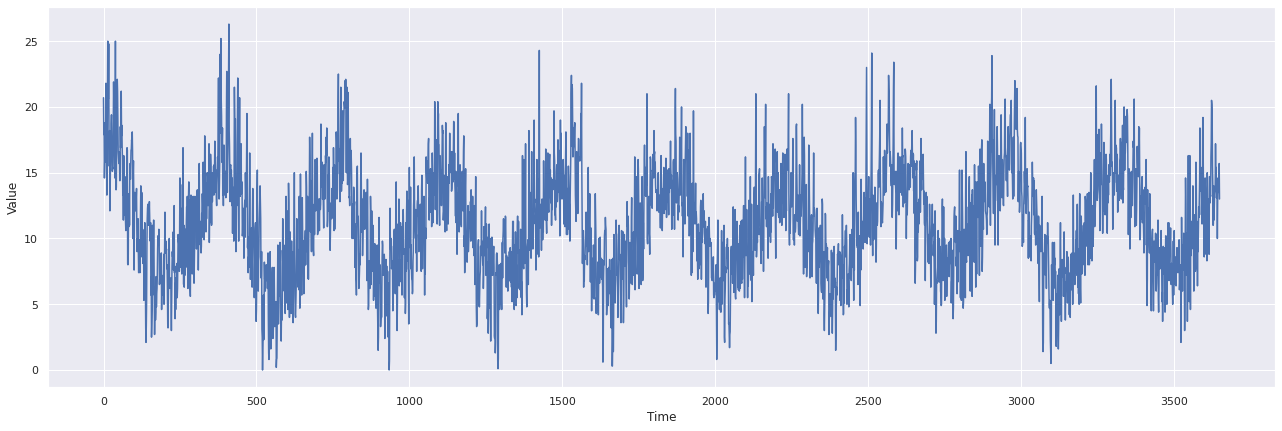

In [9]:
time_step = []
temps     = []

with open('/content/daily-min-temperatures.csv') as csvfile:
    # Reads temperatures into temps
    # Have timesteps be a simple array of 1, 2, 3, 4 ...
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    step = 0

    for row in reader:
        temps    .append(float(row[1]))
        time_step.append(step)
        step = step + 1
    
series = np.array(temps)
time   = np.array(time_step)

split_time = 2500
time_train = time  [:split_time]
time_valid = time  [split_time:]
x_train    = series[:split_time]
x_valid    = series[split_time:]

window_size         = 30
batch_size          = 32
shuffle_buffer_size = 1000

plt.figure(figsize = (22, 7))
plot_series(time, series)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series  = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    
    forecast =  model.predict(dataset)
    
    return forecast

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))> 

(2500,) 



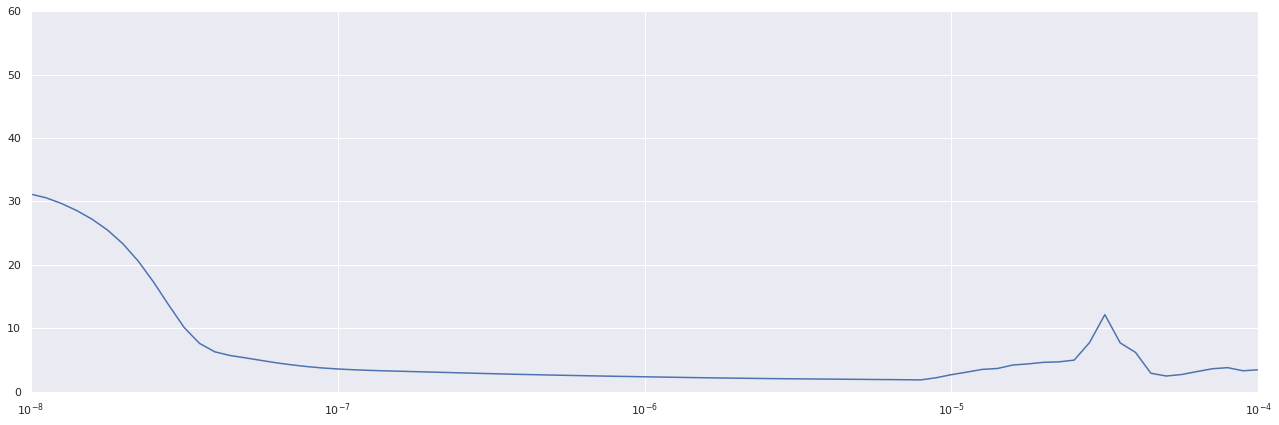

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size  = 256
train_set   = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set, '\n')
print(x_train.shape, '\n')

model = models.Sequential([
    layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, 
                  padding = 'causal', activation = 'relu', 
                  input_shape = [None, 1]),                           
    layers.LSTM(64, return_sequences = True),
    layers.LSTM(64, return_sequences = True),
    layers.Dense(30, activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400.0)                           
])

lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

model.compile(loss = losses.Huber(),
              optimizer = optimizers.SGD(learning_rate = 1e-8, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule], verbose = 0)

plt.figure(figsize = (22, 7))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])
plt.show()

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 60
batch_size  = 100
train_set   = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = models.Sequential([
    layers.Conv1D(filters = 60, kernel_size = 5, strides = 1, 
                  padding = 'causal', activation = 'relu', 
                  input_shape = [None, 1]),                           
    layers.LSTM(60, return_sequences = True),
    layers.LSTM(60, return_sequences = True),
    layers.Dense(30, activation = 'relu'),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400.0)                           
])

model.compile(loss = losses.Huber(),
              optimizer = optimizers.SGD(learning_rate = 1e-5, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs = 150, verbose = 0)

Forecast: [11.332 10.708 12.128 ... 13.605 13.797 15.01 ]

Error: 1.779740810394287


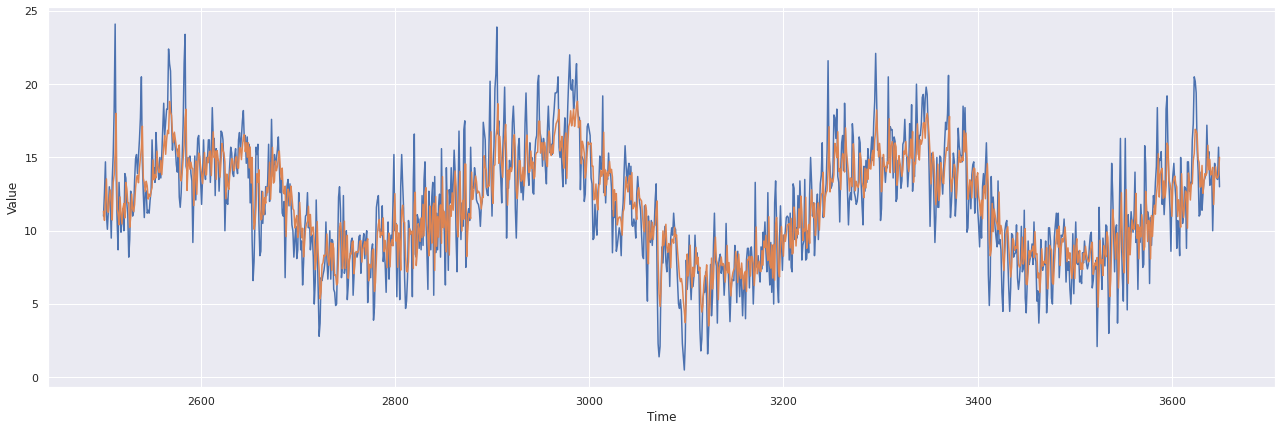

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast = np.round(rnn_forecast, 3)

plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

print(f'Forecast: {rnn_forecast}\n')
print(f'Error: {metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()}')